# IFN646 All Models

#### Importing and Installing required Libraries

In [1]:
!pip install -U scikit-learn
!pip install imbalanced-learn

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/JupyterLab.app/Contents/Resources/jlab_server/bin/python3.8 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/JupyterLab.app/Contents/Resources/jlab_server/bin/python3.8 -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import numpy as np
import glob
from collections import Counter
import datetime
import scipy.stats as stats
#import plotly.graph_objects as go

from io import StringIO

import seaborn as sn
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

# Random Forest
from sklearn.ensemble import RandomForestClassifier

#Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

# Neural Network
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

# model evaluation
from sklearn import metrics
from sklearn.metrics import roc_curve, det_curve, roc_auc_score, auc
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import RepeatedKFold

#### Functions

In [3]:
def DataPrep(data):
    #1
    data['timestamp'] = pd.to_datetime(data['timestamp'])
    # 2
    data.rename(columns = {'Actiwatch activity counts' : 'actiwatch_counts',
                           'Actiware classification' : 'actiware_class',
                           'Apple Watch ENMO' : 'Apple_ENMO'}, inplace = True)
    # 3
    data = data[data['actiware_class'].notna()]
    data = data[data['actiwatch_counts'].notna()]
    data = data[data['Apple_ENMO'].notna()]

    return(data)

In [4]:
def RF_predictor(col_name): 
    
    randomforest = RandomForestClassifier(n_estimators = 100)    
    rf_model = randomforest.fit(x_train[[col_name]], y_train)
    pred_value = randomforest.predict(x_test[[col_name]])
    
    return(rf_model,pred_value)

In [5]:
def LR_predictor(col_name):
    
    logreg = LogisticRegression()    
    lr_model = logreg.fit(x_train[[col_name]], y_train)
    pred_value = lr_model.predict(x_test[[col_name]])
    
    return(lr_model,pred_value)

In [6]:
def NN_predictor(col_name, x_train, x_test, y_train, y_test):
    
    rs = 200
    nn = MLPClassifier(max_iter=10000, random_state=rs)
    nn_model = nn.fit(x_train[[col_name]],y_train)
    pred_value = nn_model.predict(x_test[[col_name]])
    
    return(nn_model,pred_value)

In [7]:
def ModelReport(model, pred_value, col_name):
    print("Train accuracy =>", model.score(x_train[[col_name]], y_train))
    print("Test accuracy =>",model.score(x_test[[col_name]], y_test))
    print("K-fold Cross Validation =>",np.mean(cross_val_score(estimator = model, X = x_train[[col_name]], y = y_train, cv =10)))
    print("Classification Report => ")
    print(classification_report(y_test, pred_value))
    print("\n")

In [8]:
def eval_model(model, col_name):
    
    fig = plt.figure(figsize=[25, 8])
    ax = fig.add_subplot(1, 2, 1)
    conf = plot_confusion_matrix(model, x_train[[col_name]], y_train, normalize=None, xticks_rotation='vertical', ax=ax)
    pred = model.predict(x_train[[col_name]])
    conf.ax_.set_title('Training Set Performance: ' + str(sum(pred == y_train)/len(y_train)));
    
    ax = fig.add_subplot(1, 2, 2)
    conf = plot_confusion_matrix(model, x_test[[col_name]], y_test, normalize=None, xticks_rotation='vertical', ax=ax)
    pred = model.predict(x_test[[col_name]])
    conf.ax_.set_title('Testing Set Performance: ' + str(sum(pred == y_test)/len(y_test)));

In [9]:
def ROC_DET(model,col_name):
    
    scores = model.predict_proba(x_test[[col_name]])

    fig = plt.figure(figsize=[15, 7])
    fpr, tpr, thresholds = roc_curve(y_test, scores[:, 1])
    auc_score = roc_auc_score(y_test, scores[:, 1])
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(fpr, tpr)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Curve, AUC: ' + str(auc_score))

    fpr, fnr, thresholds = det_curve(y_test, scores[:, 1])
    ax = fig.add_subplot(1, 2, 2)
    ax.plot(fpr, fnr)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('False Negative Rate')
    ax.set_title('DET Curve')

In [10]:
def TST_WASO_NA(pred_value):
    sleep = 0
    wake = 0
    no_awaken = 0
    
    for i in pred_value:
        if i == 0.0:
            sleep+=1
        elif i == 1.0:
            wake+=1
    
    tst = (sleep * 15)/(60*60)
    waso = (wake * 15)/(60*60)

    tst = round (tst, 2)
    waso = round (waso, 2)
    
    for i in range(1, len(pred_value)):
        if (pred_value[i-1] == 0) & (pred_value[i] == 1):
            no_awaken += 1
            
    return(tst,waso,no_awaken)

In [11]:
def SleepTime(filename,i):
    
    global tst_apple 
    global tst_actiwatch 
    global tst_actiware 
    global waso_apple
    global waso_actiwatch
    global waso_actiware 
    global na_apple
    global na_actiwatch
    global na_actiware 

    data = pd.read_csv(filename)
    data = DataPrep(data)
    x = data[['actiwatch_counts', 'Apple_ENMO']]
    y = data['actiware_class']
    
    actiware_class = data['actiware_class'].to_numpy()

    f = data['timestamp'].iloc[0]
    l = data['timestamp'].iloc[-1]
    
    print()
    print("Day ", i)
    print("Sleep Observation on: ", f.date(), "till", l.date())
    print("bedtime: ", f.time(), "to ", l.time())
    print()

    #Apple
    nn_apple, pred_apple = NN_predictor('Apple_ENMO',x,x,y,y)
    tst, waso, no_awaken = TST_WASO_NA(pred_apple)
    tst_apple.append(tst)
    waso_apple.append(waso)
    na_apple.append(no_awaken)
    print("Sleep Observation of Apple Watch")
    print("Hours slept: ", tst)
    print("Hours wake: ", waso)
    print("Number of Awakening: ",no_awaken )
    print()

    #Actiwatch
    nn_actiwatch, pred_actiwatch = NN_predictor('actiwatch_counts',x,x,y,y)
    tst, waso, no_awaken = TST_WASO_NA(pred_actiwatch)
    tst_actiwatch.append(tst)
    waso_actiwatch.append(waso)
    na_actiwatch.append(no_awaken)
    print("Sleep Observation of Actiwatch")
    print("Hours slept: ", tst)
    print("Hours wake: ", waso)
    print("Number of Awakening: ",no_awaken )
    print()

    #Actiware Classification
    tst, waso, no_awaken = TST_WASO_NA(actiware_class)
    tst_actiware.append(tst)
    waso_actiware.append(waso)
    na_actiware.append(no_awaken)
    print("Sleep Observation as per Actiware Classification")
    print("Hours slept: ", tst)
    print("Hours wake: ", waso)
    print("Number of Awakening: ",no_awaken )
    print("----------------------------------------------------------------------")
    print()

#### Loading Data

In [ ]:
!wget https://data.researchdatafinder.qut.edu.au/dataset/b9aba9aa-d26a-4136-a4cd-660a4ea492e5/resource/0a510488-c675-4d7d-aa57-b175369d691c/download/sleepdataset.zip

In [ ]:
!unzip "sleepdataset.zip" -d "sleepdataset"

In [12]:
filenames = glob.glob("raw_data/" + "*.csv")

dfs = []
for filename in filenames:
    dfs.append(pd.read_csv(filename))
    print

# adding more cleaning process
for i in range(len(dfs)):
#     print(filenames[i])
    # adding the participants number index 16
    start = filenames[i].find("/p")
    end = filenames[i].find("_n")
    dfs[i]['participant'] = filenames[i][start + 2:end]  

    # adding night number # index 21
    start = filenames[i].find("_n")
    end = filenames[i].find("_r")
    dfs[i]['night'] = filenames[i][start + 2:end]
    
    # print the missing value
    print("Missing value in dataframe" + str(i))
    print(dfs[i].isna().sum())
    print()

    # cleaning data process
    # filling actiware all classification with 1, as the missing value are in the beginning and in the end and it seems to be the wake up time
    dfs[i]['Actiware classification'] = dfs[i]['Actiware classification'].fillna(1)
    # filling all the ENMO value with mean by dataframe
    # if there is missing ENMO removing this dataframe
    dfs[i]['Apple Watch ENMO'] = dfs[i]['Apple Watch ENMO'].fillna(dfs[i]['Apple Watch ENMO'].mean())
    # filling actiwatch activity counts with mean
    dfs[i]['Actiwatch activity counts'] = dfs[i]['Actiwatch activity counts'].fillna(dfs[i]['Apple Watch ENMO'].mean())
    
    # set timestamp as index
    dfs[i].set_index('timestamp')
  

sleepwake = pd.concat(dfs)

Missing value in dataframe0
timestamp                    0
Actiwatch activity counts    1
Actiware classification      9
Apple Watch ENMO             0
participant                  0
night                        0
dtype: int64

Missing value in dataframe1
timestamp                     0
Actiwatch activity counts     5
Actiware classification      11
Apple Watch ENMO              0
participant                   0
night                         0
dtype: int64

Missing value in dataframe2
timestamp                     0
Actiwatch activity counts     5
Actiware classification      10
Apple Watch ENMO              0
participant                   0
night                         0
dtype: int64

Missing value in dataframe3
timestamp                     0
Actiwatch activity counts    18
Actiware classification      26
Apple Watch ENMO              0
participant                   0
night                         0
dtype: int64

Missing value in dataframe4
timestamp                     0
Actiwatch 

In [41]:
sleepwake.describe()

,actiwatch_counts,actiware_class,Apple_ENMO
count,49312.000000,49312.000000,49312.000000
mean,4.092821,0.086977,0.006620
std,24.509936,0.281804,0.029232
min,0.000000,0.000000,0.000505
25%,0.000000,0.000000,0.001898
50%,0.000000,0.000000,0.003030
75%,0.000000,0.000000,0.004748
max,880.000000,1.000000,3.342039


In [42]:
metrics = sleepwake.set_index(['timestamp', 'participant', 'night'], inplace = False)
metrics.head()

,,,actiwatch_counts,actiware_class,Apple_ENMO
timestamp,participant,night,,,
2000-06-01 22:11:00,05,01,0.004406,1.0,0.047328
2000-06-01 22:11:15,05,01,91.000000,1.0,0.049485
2000-06-01 22:11:30,05,01,62.000000,1.0,0.047339
2000-06-01 22:11:45,05,01,58.000000,1.0,0.069403
2000-06-01 22:12:00,05,01,154.000000,1.0,1.066049


#### Preparing Data


1. Changed the Datatype of column 'timestamp'
2. Renamed the Column Name
3. Dealing with missing value
  - select non missing value observations 
  - fill the actiware classification with 1 as when I explore the data, the misisng value mainly occur in the beginning and in the end of the timestamp, I assume that during that time they are still awake.


In [13]:
sleepwake = DataPrep(sleepwake)

In [43]:
sleepwake.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49312 entries, 0 to 2423
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   timestamp         49312 non-null  datetime64[ns]
 1   actiwatch_counts  49312 non-null  float64       
 2   actiware_class    49312 non-null  float64       
 3   Apple_ENMO        49312 non-null  float64       
 4   participant       49312 non-null  object        
 5   night             49312 non-null  object        
dtypes: datetime64[ns](1), float64(3), object(2)
memory usage: 2.6+ MB


In [44]:
# Using counter, the count of each class is recorded
print(Counter(sleepwake['actiware_class']))

Counter({0.0: 45023, 1.0: 4289})


#### Exploratory Analysis

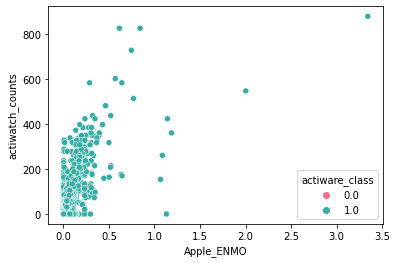

In [45]:
class_var = "actiware_class"
g = sn.scatterplot(data = sleepwake, x = "Apple_ENMO", y = "actiwatch_counts", hue = class_var, palette="husl")

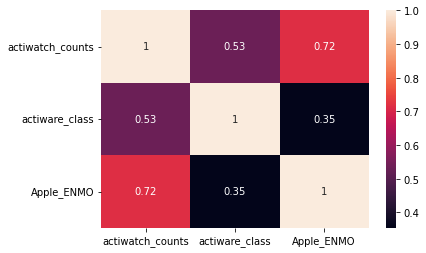

In [46]:
corrMatrix = sleepwake.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

(0.0, 0.1)

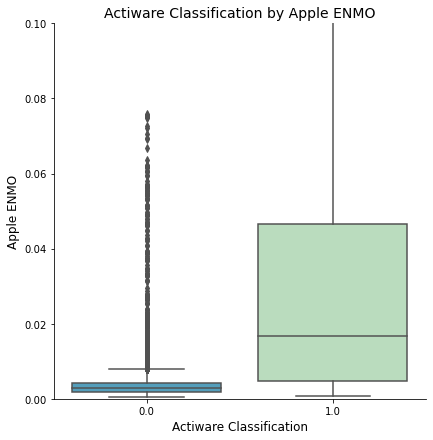

In [47]:
sn.catplot(x="actiware_class", y="Apple_ENMO", kind="box", data=sleepwake
          ,palette="GnBu_r", height=6, aspect=9/9)
plt.title("Actiware Classification by Apple ENMO", fontsize=14)
plt.xlabel("Actiware Classification", fontsize=12)
plt.ylabel("Apple ENMO", fontsize=12) 
plt.ylim(0.0,.1)

(0.0, 100.0)

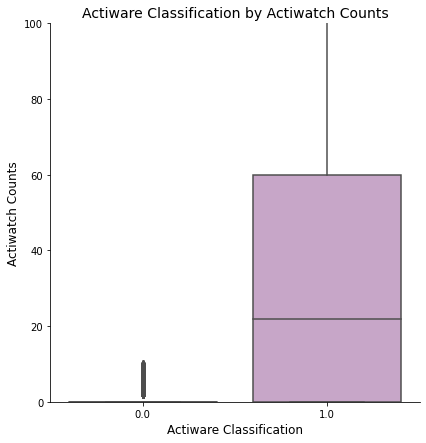

In [48]:
sn.catplot(x="actiware_class", y="actiwatch_counts", kind="box", data=sleepwake
          ,palette="PuRd_r", height=6, aspect=9/9)
plt.title("Actiware Classification by Actiwatch Counts", fontsize=14)
plt.xlabel("Actiware Classification", fontsize=12)
plt.ylabel("Actiwatch Counts", fontsize=12) 
plt.ylim(0.0,100)

#### Train-Test Split

In [14]:
x = sleepwake[['actiwatch_counts', 'Apple_ENMO']]
y = sleepwake['actiware_class']

In [ ]:
from imblearn.over_sampling import SMOTE as sm
over = SMOTE(sampling_strategy=0.1)

X_sm, y_sm = sm.fit_resample(x, y)

print(f'''Shape of X before SMOTE: {x.shape}
Shape of X after SMOTE: {X_sm.shape}''')

print('\nBalance of positive and negative classes (%):')
y_sm.value_counts(normalize=True) * 100

In [15]:
global x_train, x_test, y_train, y_test
#global x_train
#global x_test
#global y_train
#global y_test

#x_train, x_test, y_train, y_test = train_test_split(x_sm,y_sm,test_size = 0.3, random_state=10)

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.3, random_state=10)

# Random Forest

In [16]:
# Apple Watch
rf_model_apple, rf_pred_apple = RF_predictor('Apple_ENMO')

# Actiwatch
rf_model_actiwatch, rf_pred_actiwatch = RF_predictor('actiwatch_counts')

#### Acurracies

In [17]:
print("\n")
print("Apple Watch")
print("------------")
ModelReport(rf_model_apple, rf_pred_apple,'Apple_ENMO')

print("Actiwatch")
print("------------")
ModelReport(rf_model_actiwatch, rf_pred_actiwatch,'actiwatch_counts')



Apple Watch
------------
Train accuracy => 0.9814010081696506
Test accuracy => 0.9372718669730972
K-fold Cross Validation => 0.9368445524212003
Classification Report => 
              precision    recall  f1-score   support

         0.0       0.96      0.97      0.97     13519
         1.0       0.66      0.56      0.61      1275

    accuracy                           0.94     14794
   macro avg       0.81      0.77      0.79     14794
weighted avg       0.93      0.94      0.93     14794



Actiwatch
------------
Train accuracy => 0.9741294397126137
Test accuracy => 0.9726916317425983
K-fold Cross Validation => 0.9741293436701808
Classification Report => 
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99     13519
         1.0       0.97      0.70      0.82      1275

    accuracy                           0.97     14794
   macro avg       0.97      0.85      0.90     14794
weighted avg       0.97      0.97      0.97     14794





#### Confusion Matrix [Apple Watch]

In [18]:
cnf_matrix_ap = metrics.confusion_matrix(y_test, rf_pred_apple)
print(cnf_matrix_ap)

[[13152   367]
 [  561   714]]


/Users/devikanair/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/Users/devikanair/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


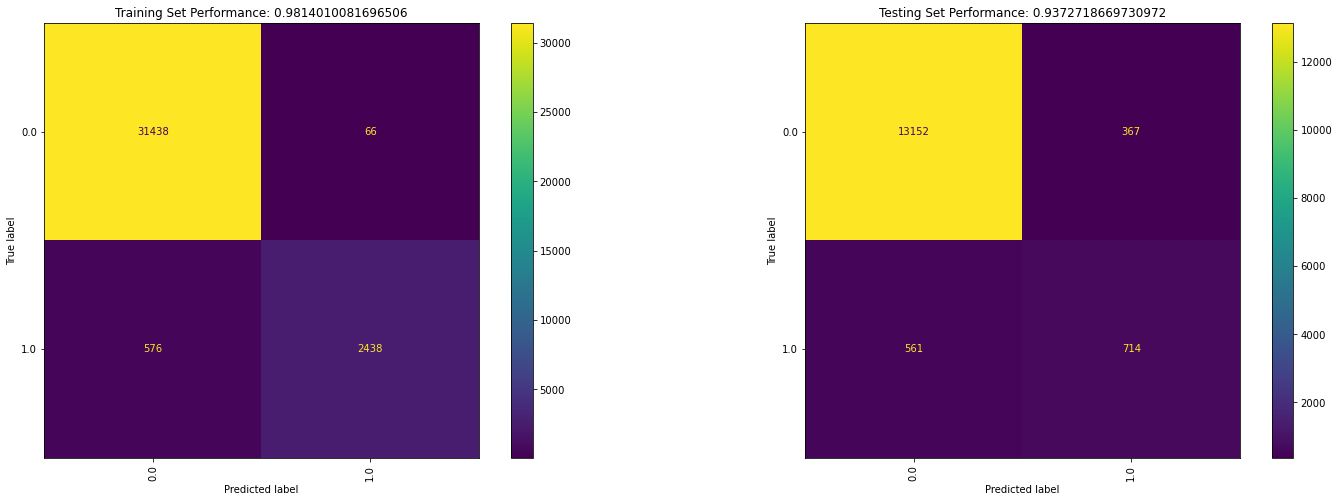

In [20]:
eval_model(rf_model_apple,'Apple_ENMO')

#### Confusion Matrix [Actiwatch]

In [21]:
cnf_matrix_ac = metrics.confusion_matrix(y_test, rf_pred_actiwatch)
print(cnf_matrix_ac)

[[13494    25]
 [  379   896]]


/Users/devikanair/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/Users/devikanair/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


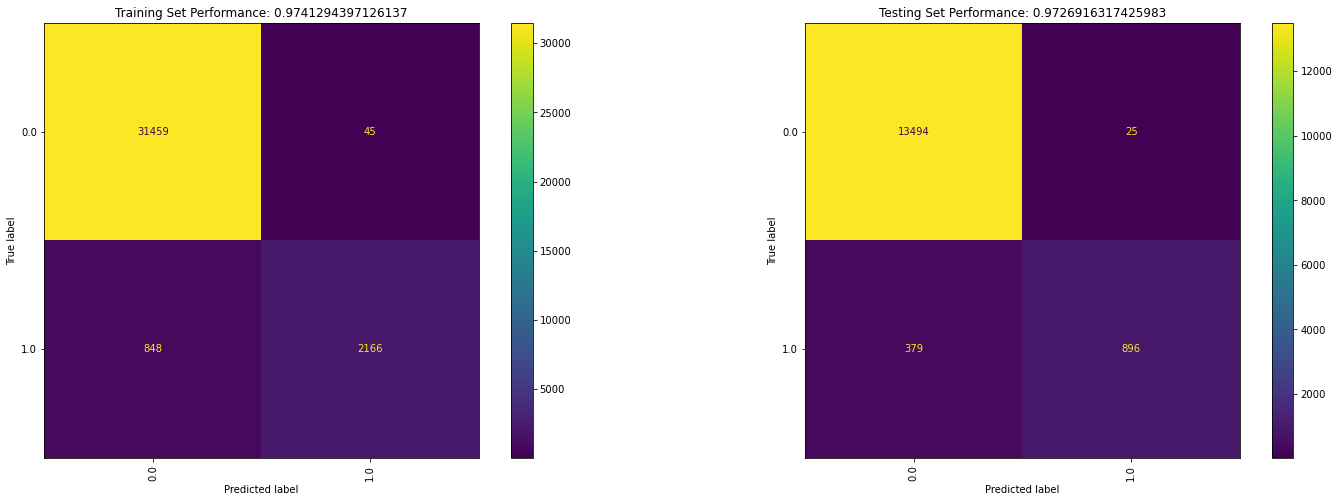

In [22]:
eval_model(rf_model_actiwatch,'actiwatch_counts')

#### ROC and DET Curve

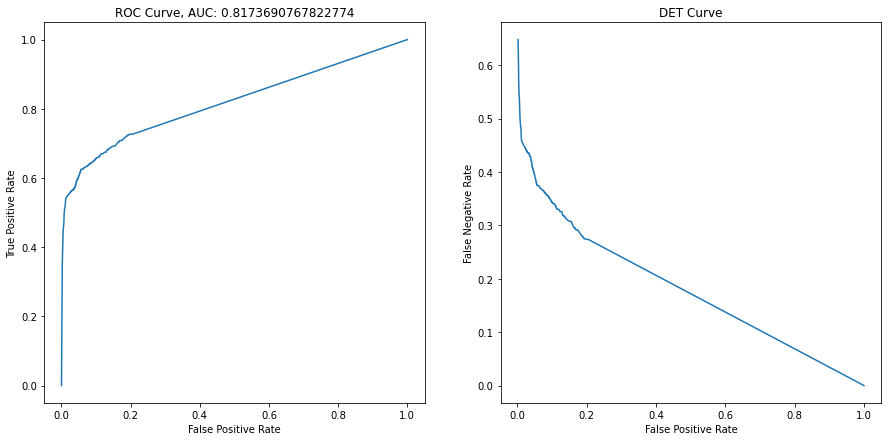

In [23]:
ROC_DET(rf_model_apple,'Apple_ENMO')

# Logistic Regression

In [24]:
# Applw watch
lr_model_apple, lr_pred_apple = LR_predictor('Apple_ENMO')

# Actiwatch
lr_model_actiwatch, lr_pred_actiwatch = LR_predictor('actiwatch_counts')

#### Acurracies

In [25]:
print("\n")
print("Apple Watch")
print("------------")
ModelReport(lr_model_apple, lr_pred_apple,'Apple_ENMO')

print("Actiwatch")
print("------------")
ModelReport(lr_model_actiwatch, lr_pred_actiwatch,'actiwatch_counts')



Apple Watch
------------
Train accuracy => 0.925748884639898
Test accuracy => 0.9258483168852237
K-fold Cross Validation => 0.9250247128059679
Classification Report => 
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96     13519
         1.0       0.99      0.14      0.25      1275

    accuracy                           0.93     14794
   macro avg       0.96      0.57      0.60     14794
weighted avg       0.93      0.93      0.90     14794



Actiwatch
------------
Train accuracy => 0.969783880873747
Test accuracy => 0.9680275787481412
K-fold Cross Validation => 0.9697838519273135
Classification Report => 
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98     13519
         1.0       0.96      0.66      0.78      1275

    accuracy                           0.97     14794
   macro avg       0.96      0.83      0.88     14794
weighted avg       0.97      0.97      0.97     14794





#### Confusion Matrix [Apple Watch]

In [26]:
cnf_matrix = metrics.confusion_matrix(y_test, lr_pred_apple)
print("Confusion Matrix for Apple Watch ENMO")
print(cnf_matrix)

Confusion Matrix for Apple Watch ENMO
[[13518     1]
 [ 1096   179]]


/Users/devikanair/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/Users/devikanair/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


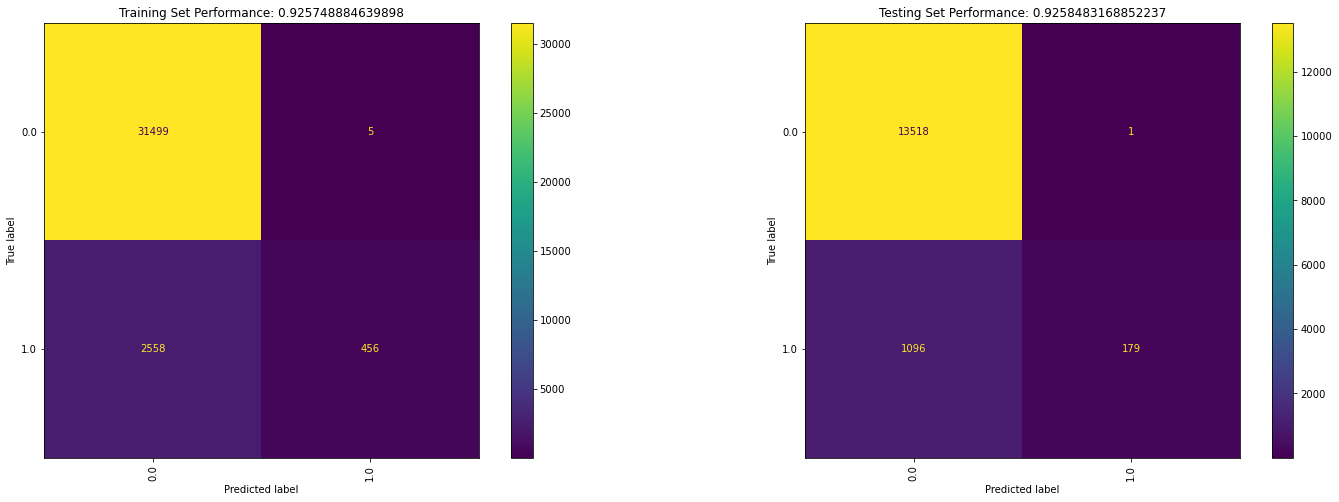

In [27]:
eval_model(lr_model_apple, 'Apple_ENMO')

#### Confusion Matrix [Actiwatch]

In [28]:
cnf_matrix2 = metrics.confusion_matrix(y_test, lr_pred_actiwatch)
print("Confusion Matrix for Actiwatch activity counts")
print(cnf_matrix2)

Confusion Matrix for Actiwatch activity counts
[[13484    35]
 [  438   837]]


/Users/devikanair/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/Users/devikanair/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


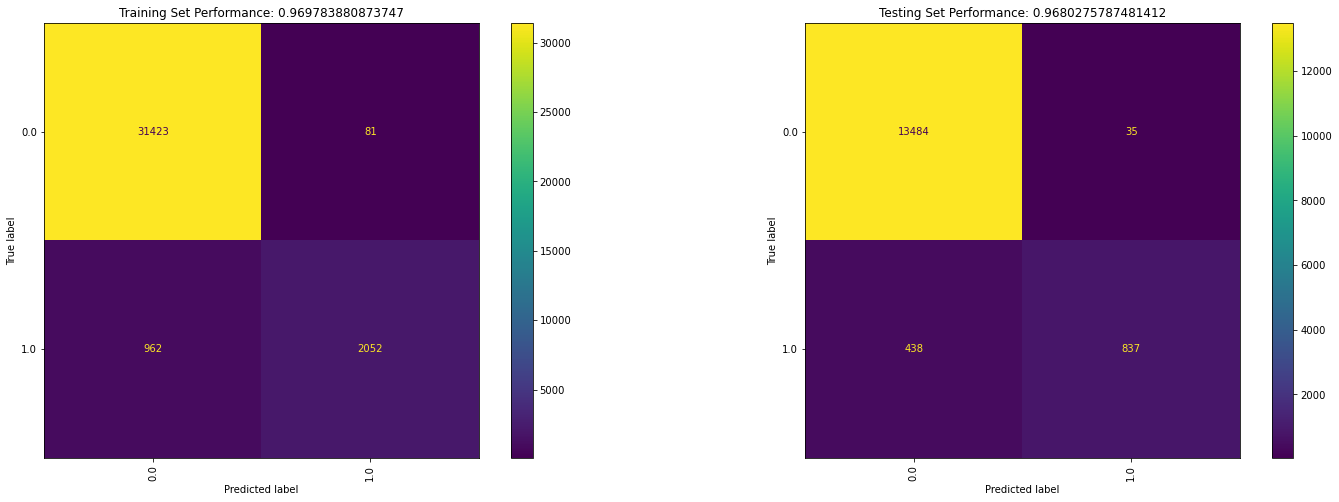

In [29]:
eval_model(lr_model_actiwatch, 'actiwatch_counts')

#### ROC and DET Curve [Apple Watch]


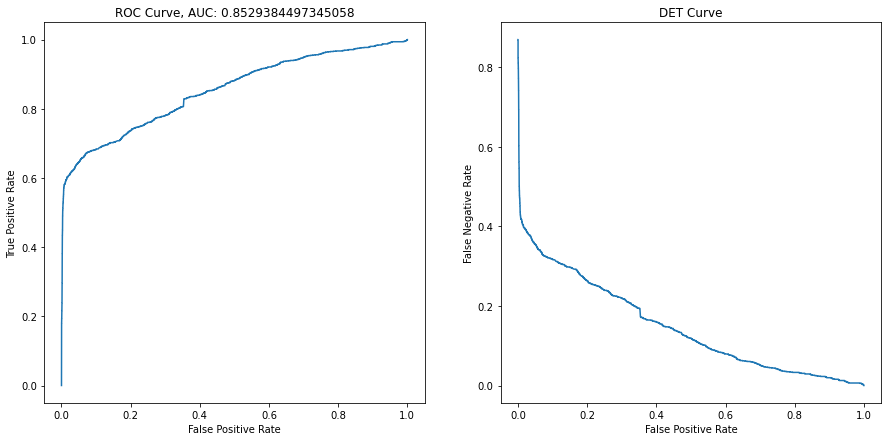

In [30]:
ROC_DET(lr_model_apple,'Apple_ENMO')

#### k-fold cross validation [Apple Watch]


# Neural Network

In [31]:
#Apple
nn_apple, nn_pred_apple = NN_predictor('Apple_ENMO',x_train, x_test, y_train, y_test)

#Actiwatch
nn_actiwatch, nn_pred_actiwatch = NN_predictor('actiwatch_counts',x_train, x_test, y_train, y_test)

#### Acurracies

In [32]:
print("\n")
print("Apple Watch")
print("------------")
ModelReport(nn_apple, nn_pred_apple,'Apple_ENMO')

print("Actiwatch")
print("------------")
ModelReport(nn_actiwatch, nn_pred_actiwatch,'actiwatch_counts')



Apple Watch
------------
Train accuracy => 0.9563995596500376
Test accuracy => 0.9553197242125185
K-fold Cross Validation => 0.9561387734859796
Classification Report => 
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.98     13519
         1.0       0.91      0.54      0.67      1275

    accuracy                           0.96     14794
   macro avg       0.93      0.77      0.82     14794
weighted avg       0.95      0.96      0.95     14794



Actiwatch
------------
Train accuracy => 0.969783880873747
Test accuracy => 0.9680275787481412
K-fold Cross Validation => 0.9697838519273135
Classification Report => 
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98     13519
         1.0       0.96      0.66      0.78      1275

    accuracy                           0.97     14794
   macro avg       0.96      0.83      0.88     14794
weighted avg       0.97      0.97      0.97     14794





#### Confusion Matrix [Apple Watch]

In [33]:
cnf_matrix_nn = metrics.confusion_matrix(y_test, nn_pred_apple)
print(cnf_matrix_nn)

[[13450    69]
 [  592   683]]


/Users/devikanair/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/Users/devikanair/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


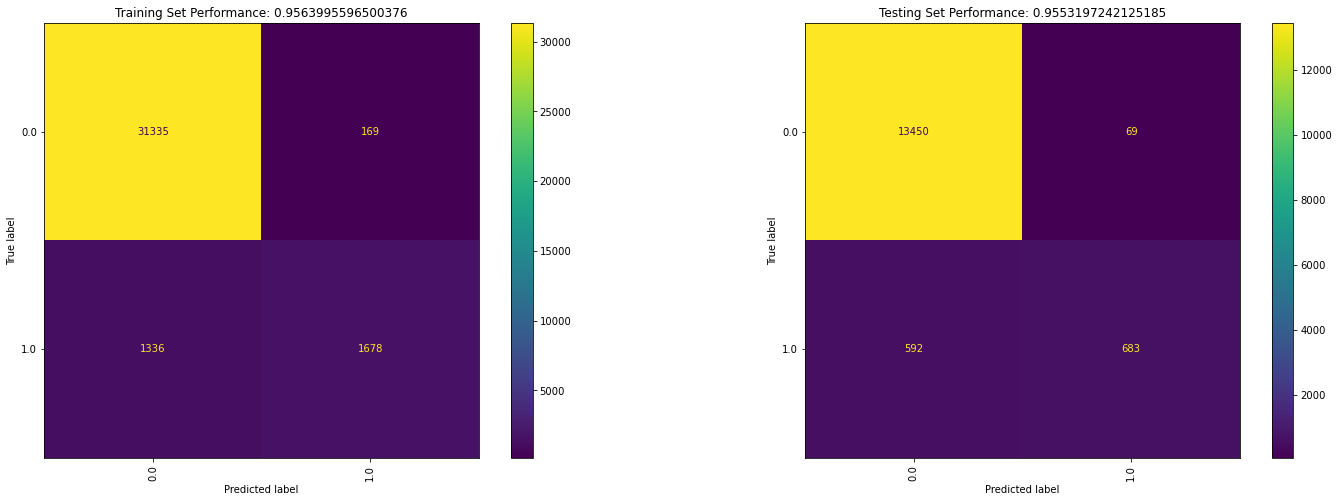

In [34]:
eval_model(nn_apple, 'Apple_ENMO')

#### Confusion Matrix [Actiwatch]

In [35]:
cnf_matrix_nn = metrics.confusion_matrix(y_test, nn_pred_actiwatch)
print(cnf_matrix_nn)

[[13484    35]
 [  438   837]]


/Users/devikanair/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/Users/devikanair/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


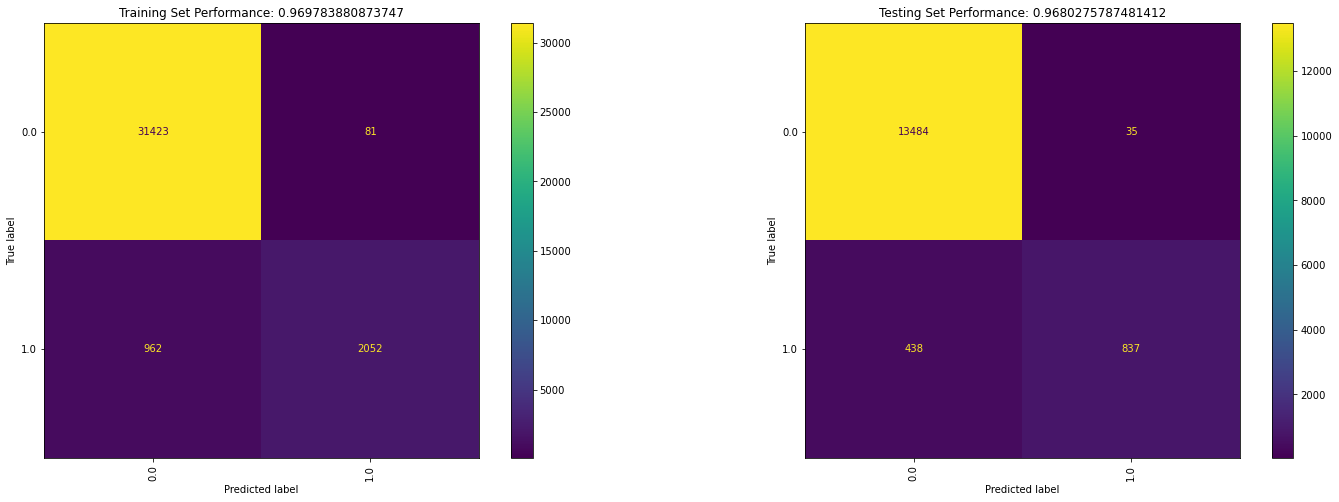

In [36]:
eval_model(nn_actiwatch, 'actiwatch_counts')

#### ROC and DET curve

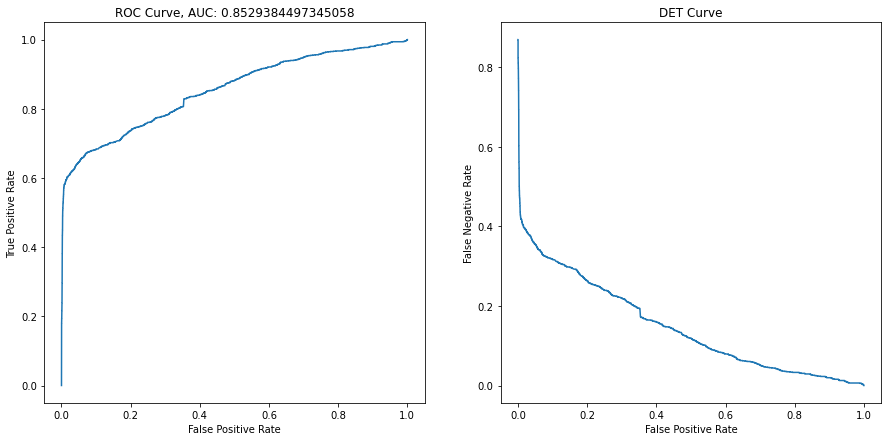

In [37]:
ROC_DET(nn_apple,'Apple_ENMO')

# Comparing three model

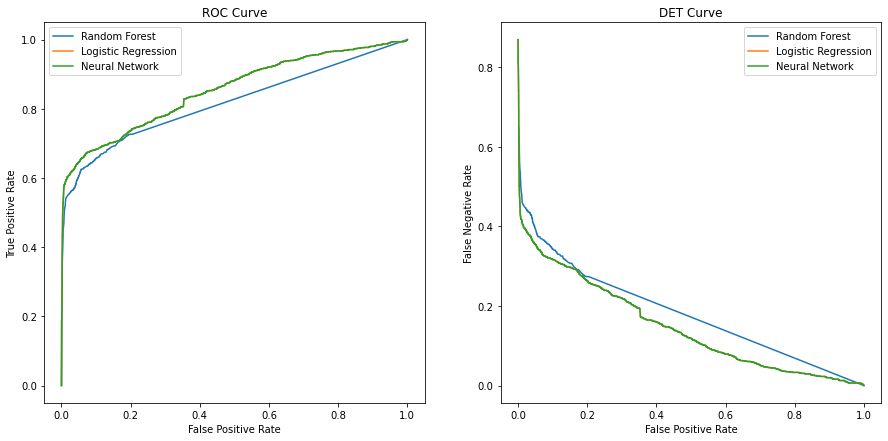

In [38]:
rf_scores = rf_model_apple.predict_proba(x_test[['Apple_ENMO']])
lg_scores = lr_model_apple.predict_proba(x_test[['Apple_ENMO']])
nn_scores = nn_apple.predict_proba(x_test[['Apple_ENMO']])

fig = plt.figure(figsize=[15, 7])
ax = fig.add_subplot(1, 2, 1)
fpr, tpr, thresholds = roc_curve(y_test, rf_scores[:, 1])
ax.plot(fpr, tpr)
fpr, tpr, thresholds = roc_curve(y_test, lg_scores[:, 1])
ax.plot(fpr, tpr)
fpr, tpr, thresholds = roc_curve(y_test, nn_scores[:, 1])
ax.plot(fpr, tpr)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve')
ax.legend(['Random Forest', 'Logistic Regression', 'Neural Network'])

ax = fig.add_subplot(1, 2, 2)
fpr, fnr, thresholds = det_curve(y_test, rf_scores[:, 1])
ax.plot(fpr, fnr)
fpr, fnr, thresholds = det_curve(y_test, lg_scores[:, 1])
ax.plot(fpr, fnr)
fpr, fnr, thresholds = det_curve(y_test, nn_scores[:, 1])
ax.plot(fpr, fnr)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('False Negative Rate')
ax.set_title('DET Curve')
ax.legend(['Random Forest', 'Logistic Regression', 'Neural Network'])

# Sleep Observation

In [39]:
filenames = glob.glob("raw_data/" + "*.csv")
i =0

tst_apple = []
tst_actiwatch = []
tst_actiware = []
waso_apple=[]
waso_actiwatch=[]
waso_actiware = []
na_apple=[]
na_actiwatch=[]
na_actiware = []

for filename in filenames:
    i +=1
    SleepTime(filename,i)


Day  1
Sleep Observation on:  2000-06-01 till 2000-07-01
bedtime:  22:12:15 to  05:10:45

Sleep Observation of Apple Watch
Hours slept:  6.98
Hours wake:  0.0
Number of Awakening:  0

Sleep Observation of Actiwatch
Hours slept:  6.85
Hours wake:  0.13
Number of Awakening:  24

Sleep Observation as per Actiware Classification
Hours slept:  6.83
Hours wake:  0.15
Number of Awakening:  24
----------------------------------------------------------------------


Day  2
Sleep Observation on:  2000-01-18 till 2000-01-18
bedtime:  00:21:30 to  07:59:30

Sleep Observation of Apple Watch
Hours slept:  7.21
Hours wake:  0.42
Number of Awakening:  70

Sleep Observation of Actiwatch
Hours slept:  7.1
Hours wake:  0.54
Number of Awakening:  94

Sleep Observation as per Actiware Classification
Hours slept:  6.92
Hours wake:  0.72
Number of Awakening:  84
----------------------------------------------------------------------


Day  3
Sleep Observation on:  2000-01-24 till 2000-01-25
bedtime:  22:47:1

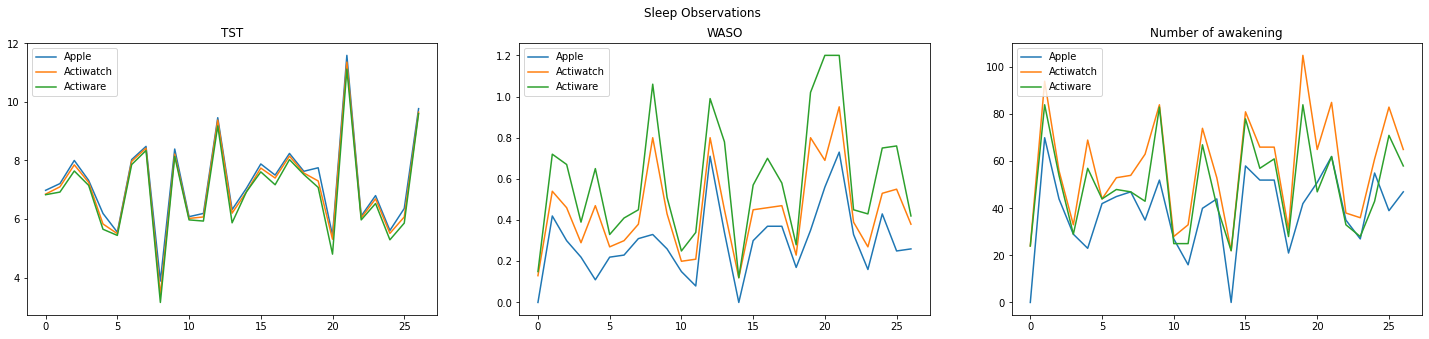

In [40]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figheight(5)
fig.set_figwidth(25)
fig.suptitle('Sleep Observations')

ax1.plot(tst_apple, label="Apple")
ax1.plot(tst_actiwatch, label="Actiwatch")
ax1.plot(tst_actiware, label="Actiware")
ax1.set_title("TST")
ax1.legend(loc="upper left")

ax2.plot(waso_apple, label="Apple")
ax2.plot(waso_actiwatch, label="Actiwatch")
ax2.plot(waso_actiware, label="Actiware")
ax2.set_title("WASO")
ax2.legend(loc="upper left")

ax3.plot(na_apple, label="Apple")
ax3.plot(na_actiwatch, label="Actiwatch")
ax3.plot(na_actiware, label="Actiware")
ax3.set_title("Number of awakening")
ax3.legend(loc="upper left")
